# COVID-19 in Australia (from covidlive.com.au)

NOTE: Because the [covidlive](https://covidlive.com.au/) database is being updated throughout the day, it only makes sense to run this notebook at the end of the day when all of the data has been loaded for the day. In the last cell of this notebook, I warn where last-day data is missing (or looks odd), but this is imperfect.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span><ul class="toc-item"><li><span><a href="#Usual-imports-etc." data-toc-modified-id="Usual-imports-etc.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Usual imports etc.</a></span></li><li><span><a href="#Other-useful-information" data-toc-modified-id="Other-useful-information-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Other useful information</a></span></li><li><span><a href="#Warnings" data-toc-modified-id="Warnings-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Warnings</a></span></li><li><span><a href="#State-populations-and-per-capita-calculations" data-toc-modified-id="State-populations-and-per-capita-calculations-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>State populations and per capita calculations</a></span></li></ul></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Capture-cumulative-and-daily-data-for-selected-columns" data-toc-modified-id="Capture-cumulative-and-daily-data-for-selected-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Capture cumulative and daily data for selected columns</a></span></li><li><span><a href="#Weekly-charts" data-toc-modified-id="Weekly-charts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Weekly charts</a></span></li><li><span><a href="#Bar-Charts" data-toc-modified-id="Bar-Charts-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bar Charts</a></span></li><li><span><a href="#Active-Cases" data-toc-modified-id="Active-Cases-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Active Cases</a></span><ul class="toc-item"><li><span><a href="#Bar-chart-of-active-cases" data-toc-modified-id="Bar-chart-of-active-cases-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Bar chart of active cases</a></span></li><li><span><a href="#Active-cases---line-plots" data-toc-modified-id="Active-cases---line-plots-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Active cases - line plots</a></span></li></ul></li><li><span><a href="#Source-of-infection" data-toc-modified-id="Source-of-infection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Source of infection</a></span></li><li><span><a href="#Local-cases---speculative" data-toc-modified-id="Local-cases---speculative-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Local cases - speculative</a></span><ul class="toc-item"><li><span><a href="#Create-dataframe-of-local-tranmission" data-toc-modified-id="Create-dataframe-of-local-tranmission-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Create dataframe of local tranmission</a></span></li><li><span><a href="#Bar-charts-cumulative-local-transmission" data-toc-modified-id="Bar-charts-cumulative-local-transmission-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Bar charts cumulative local transmission</a></span></li><li><span><a href="#Weekly-charts-for-local-transmission" data-toc-modified-id="Weekly-charts-for-local-transmission-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Weekly charts for local transmission</a></span></li><li><span><a href="#Recent-local-transmission-daily-charts" data-toc-modified-id="Recent-local-transmission-daily-charts-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Recent local transmission daily charts</a></span></li><li><span><a href="#Compare-Sydney-and-Melbourne-outbreaks" data-toc-modified-id="Compare-Sydney-and-Melbourne-outbreaks-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>Compare Sydney and Melbourne outbreaks</a></span></li><li><span><a href="#The-bigger-cumulative-comparison" data-toc-modified-id="The-bigger-cumulative-comparison-8.6"><span class="toc-item-num">8.6&nbsp;&nbsp;</span>The bigger cumulative comparison</a></span></li><li><span><a href="#Bond/Sydney-Local-Cases-Growth-Factor" data-toc-modified-id="Bond/Sydney-Local-Cases-Growth-Factor-8.7"><span class="toc-item-num">8.7&nbsp;&nbsp;</span>Bond/Sydney Local Cases Growth Factor</a></span></li></ul></li><li><span><a href="#Hospitalised" data-toc-modified-id="Hospitalised-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Hospitalised</a></span></li><li><span><a href="#The-End" data-toc-modified-id="The-End-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python set-up

### Usual imports etc.

In [1]:
# global imports
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.units as munits
import matplotlib.dates as mdates
import datetime

from pathlib import Path
from typing import Dict, List

# local imports
sys.path.append(r'../bin')
import plotstuff as ps
import Henderson

#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting
plt.style.use('ggplot')

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

### Other useful information

In [2]:
# save location
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!AS2-'

SOURCE = 'Source: https://covidlive.com.au/'

AU_COLOURS = ['#dd0000', 'darkorange', 'gold', 'seagreen',
              'dodgerblue', 'blue', 'mediumorchid', 'hotpink',
              '#555555']  

# used in charts of the recent period
RECENT = 62 # days

### Warnings

In [3]:
warning_count = 0
warnings = []

def warn(message: str) -> None:
    if message:
        print(message)
        warnings.append(message)
    global warning_count
    warning_count += 1
    return None

def print_warnings() -> None:
    if warning_count == 0:
        return None
    
    print(f'NOTE: {warning_count} warning{"s" if warning_count > 1 else ""}')

    [print(m) for m in warnings]
    return None

### State populations and per capita calculations

In [4]:
# Constants across all tests
state_pop = {
    # source: https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/latest-release
    # population at 30 June 2020
    'NSW':        8_164_100,
    'Victoria':   6_694_900,
    'Queensland': 5_174_400,
    'SA':         1_769_300,
    'WA':         2_661_900,
    'Tasmania':     540_600,
    'ACT':          431_100,
    'NT':           246_000,
}
state_pop["Australia"] = sum(state_pop.values())
print(f'Australian population: {state_pop["Australia"]:,}')

# per capita ...
power = 6
power_conversion = {
    0:  'Unit',
    3:  'Thousand',
    6:  'Million', # beyond here is a bit silly ...
    9:  'Billion', 
    12: 'Trillion',
    15: 'Quadrillion',
    18: 'Quintillion',
}
if power not in power_conversion.keys():
    power = 6
power_text = power_conversion[power]
factor = 10 ** power
state_pop = pd.Series(state_pop) / factor

Australian population: 25,682,300


## Get the data

In [5]:
def get_data_from_JSON():
    """ Get the latest data from covidlive.com.au
        Return the complete DataFrame downloaded 
        from covidlive.com.au"""
    
    # get the data
    url = 'https://covidlive.com.au/covid-live.json'
    data = pd.read_json(url)

    # convert REPORT_DATE to pandas Series of datetime64 items
    data.REPORT_DATE = pd.to_datetime(data.REPORT_DATE)
        
    # issue a warning if records exist ahead of today
    today = pd.Timestamp(datetime.datetime.now().date())
    if (data.REPORT_DATE > today).any():
        warn(f'Warning: There are records into the future?')
        all_frame = all_frame[data.REPORT_DATE <= today]

    # return
    return data

In [6]:
# obtain the latest data ...
frame_data = get_data_from_JSON()

In [7]:
# Quick peak at the data columns
frame_data.columns

Index(['REPORT_DATE', 'LAST_UPDATED_DATE', 'CODE', 'NAME', 'CASE_CNT',
       'TEST_CNT', 'DEATH_CNT', 'RECOV_CNT', 'MED_ICU_CNT', 'MED_VENT_CNT',
       'MED_HOSP_CNT', 'SRC_OVERSEAS_CNT', 'SRC_INTERSTATE_CNT',
       'SRC_CONTACT_CNT', 'SRC_UNKNOWN_CNT', 'SRC_INVES_CNT', 'PREV_CASE_CNT',
       'PREV_TEST_CNT', 'PREV_DEATH_CNT', 'PREV_RECOV_CNT', 'PREV_MED_ICU_CNT',
       'PREV_MED_VENT_CNT', 'PREV_MED_HOSP_CNT', 'PREV_SRC_OVERSEAS_CNT',
       'PREV_SRC_INTERSTATE_CNT', 'PREV_SRC_CONTACT_CNT',
       'PREV_SRC_UNKNOWN_CNT', 'PREV_SRC_INVES_CNT', 'PROB_CASE_CNT',
       'PREV_PROB_CASE_CNT', 'ACTIVE_CNT', 'PREV_ACTIVE_CNT', 'NEW_CASE_CNT',
       'PREV_NEW_CASE_CNT', 'VACC_DIST_CNT', 'PREV_VACC_DIST_CNT',
       'VACC_DOSE_CNT', 'PREV_VACC_DOSE_CNT', 'VACC_PEOPLE_CNT',
       'PREV_VACC_PEOPLE_CNT', 'VACC_AGED_CARE_CNT', 'PREV_VACC_AGED_CARE_CNT',
       'VACC_GP_CNT', 'PREV_VACC_GP_CNT'],
      dtype='object')

In [8]:
# Quick look at the categorising column
frame_data.NAME.unique()

array(['Australia', 'NSW', 'Victoria', 'Queensland', 'WA', 'SA',
       'Tasmania', 'ACT', 'NT'], dtype=object)

## Capture cumulative and daily data for selected columns

In [9]:
selected_cols = {
    # column name      # plain English for charts
    'CASE_CNT':        'cases',
    'DEATH_CNT':       'deaths',
    'TEST_CNT':        'tests',
    'VACC_DOSE_CNT':   'vacc doses',
    'VACC_PEOPLE_CNT': 'vacc people',
}

In [10]:
def get_pivot_table(frame_data, column):
    
    table = (
        frame_data
        .pivot(index='REPORT_DATE', columns='NAME', values=column)
        .sort_index(ascending=True)
    )
    
    # check if missing values in last row ...
    situation = table.iloc[-1].isna() & table.iloc[-2].notna()
    if situation.sum():
        warn(f'It looks like we are missing the latest {column} '
             f'for {", ".join(situation[situation].index.to_list())}')
        
    # check if last cumulative value is less than its predecessor ...
    not_max = table.iloc[-1] < table.iloc[-2]
    if not_max.sum():
        warn(f'Lastest value less than its predecessor in {column} '
             f'for {", ".join(not_max[not_max].index.to_list())}')

    return (table)

In [11]:
cum_u = {}
daily_u = {}
daily_c = {}
cum_c = {}

for item in selected_cols.keys():
    # cimulative totals uncorrected
    cum_u[item] = (
        get_pivot_table(frame_data, item)
        .replace({0: np.nan})
        .ffill()
        .fillna(0)
        .astype(int)
    )
    
    # adjusted caily and cumulative data (for corrections)
    daily_u[item], daily_c[item], cum_c[item] = (
        ps.dataframe_correction(cum_u[item], verbose=False))
    

## Weekly charts

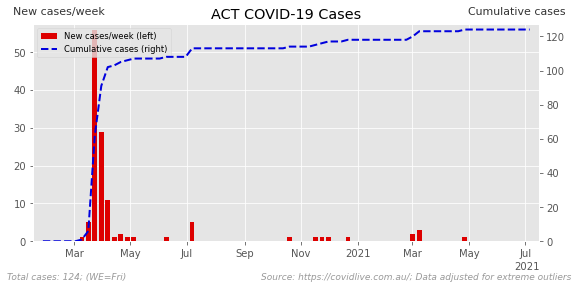

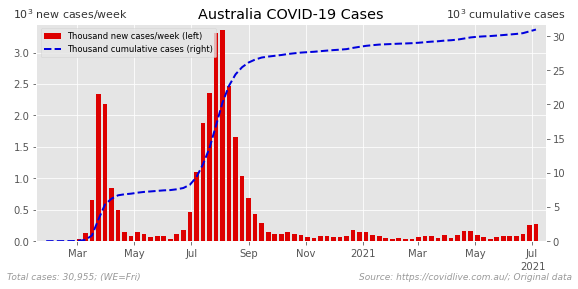

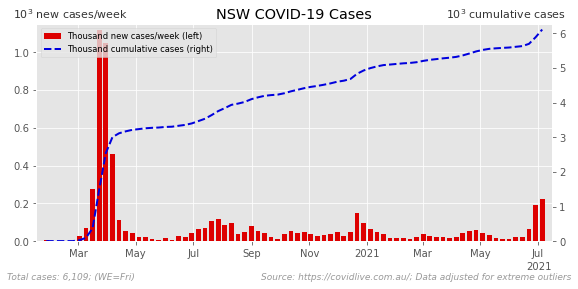

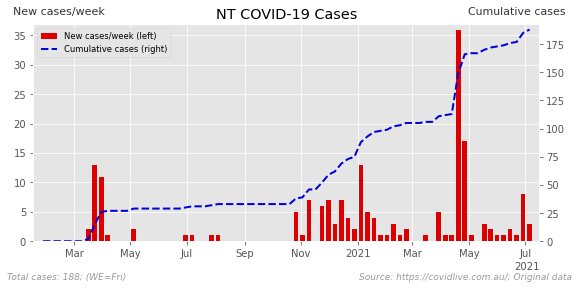

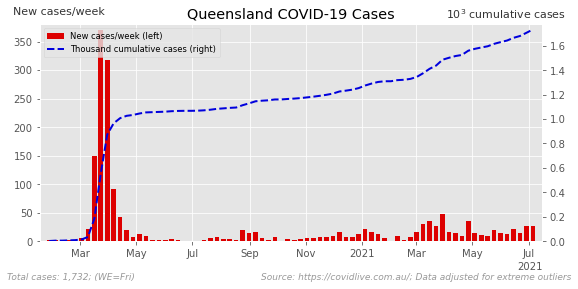

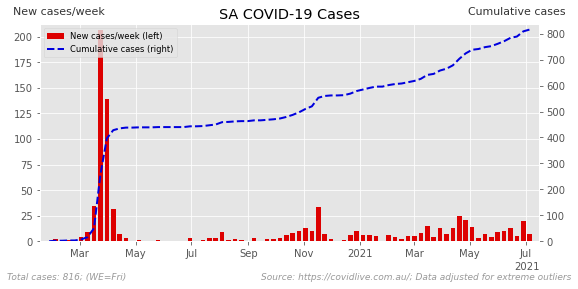

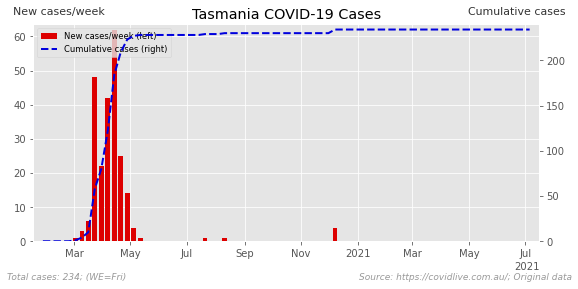

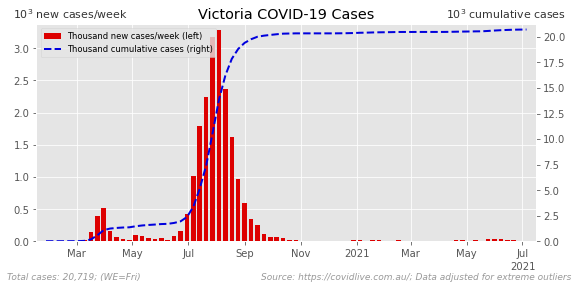

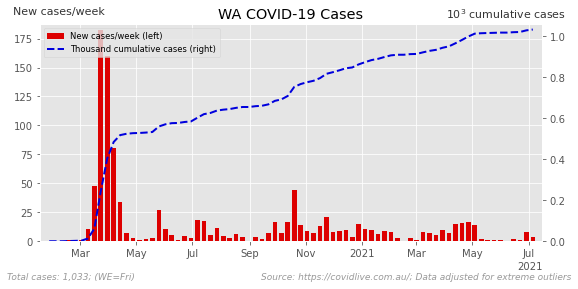

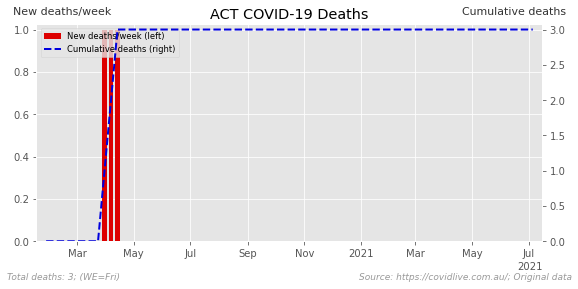

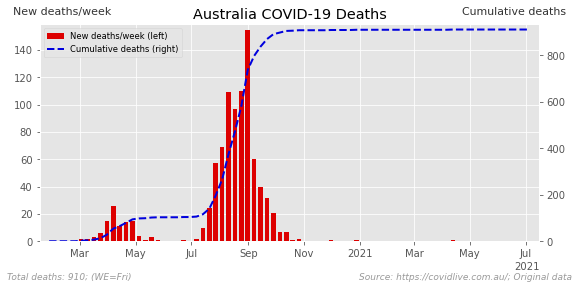

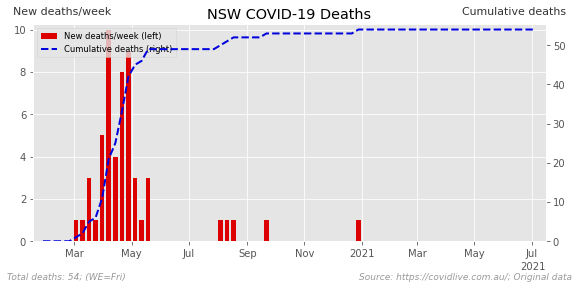

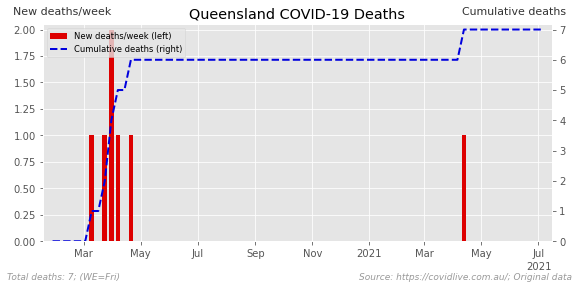

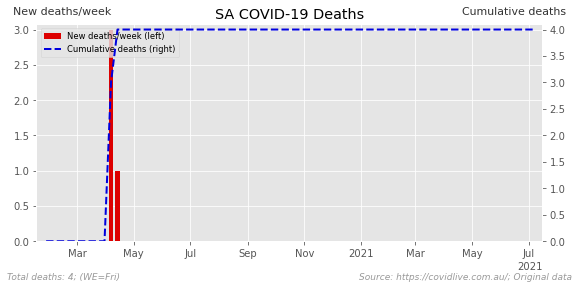

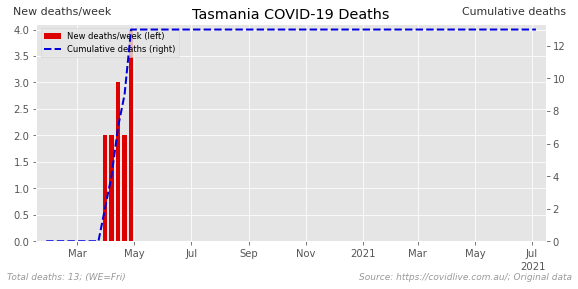

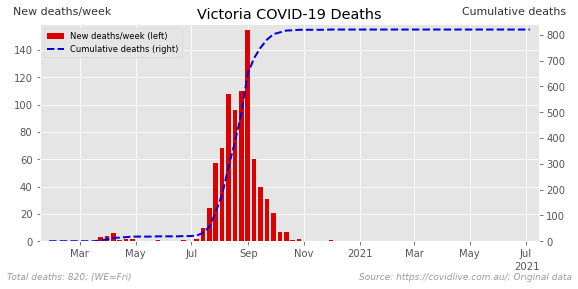

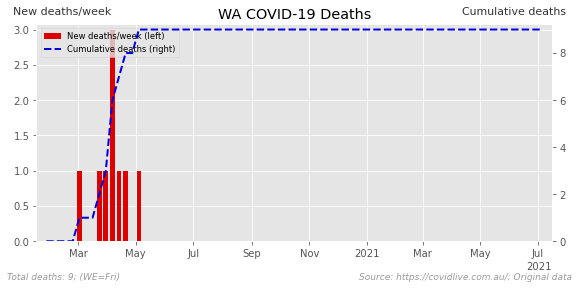

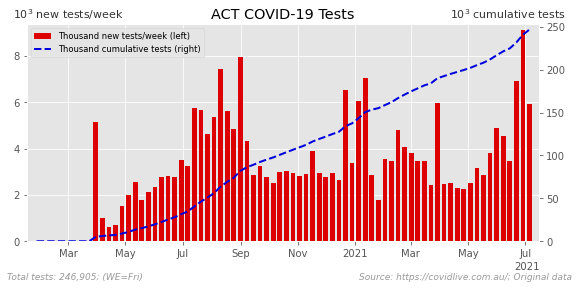

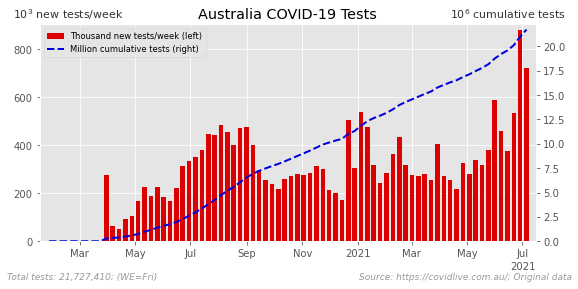

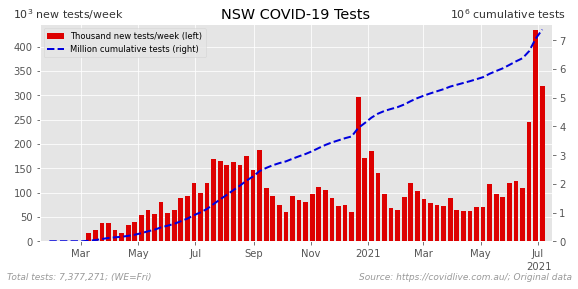

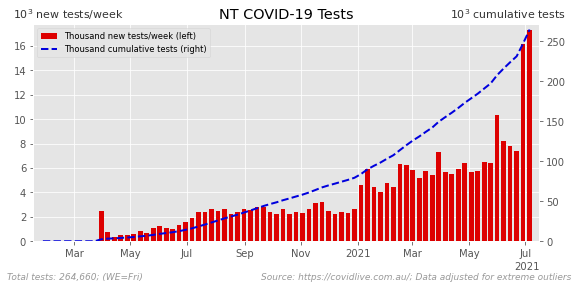

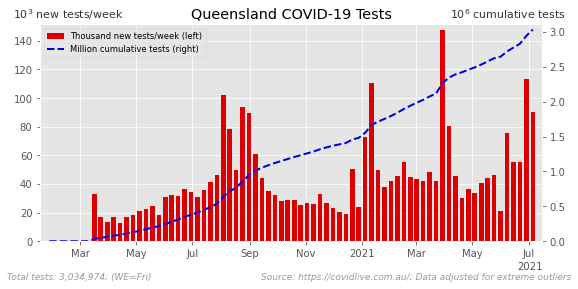

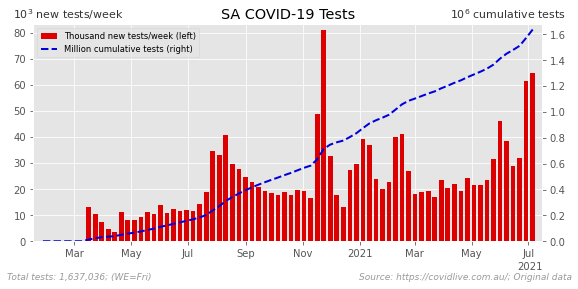

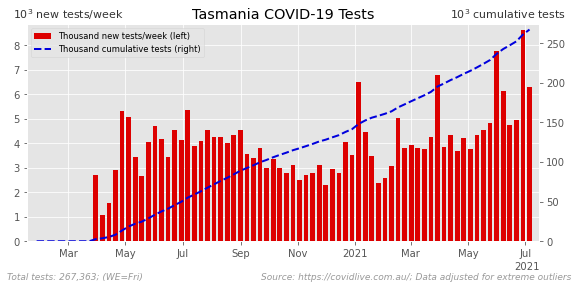

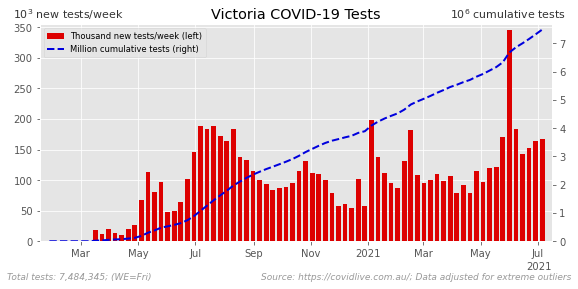

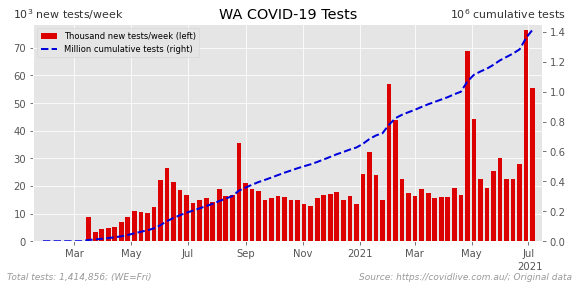

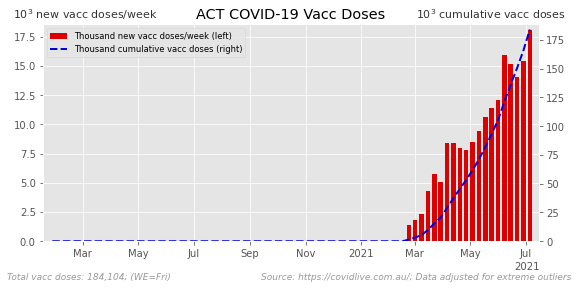

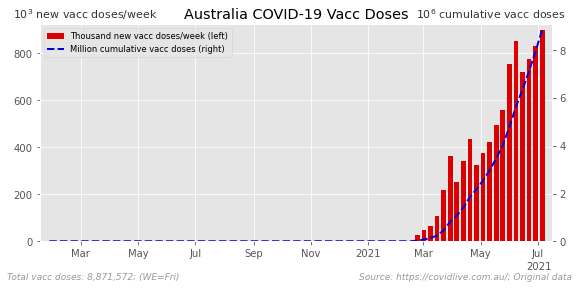

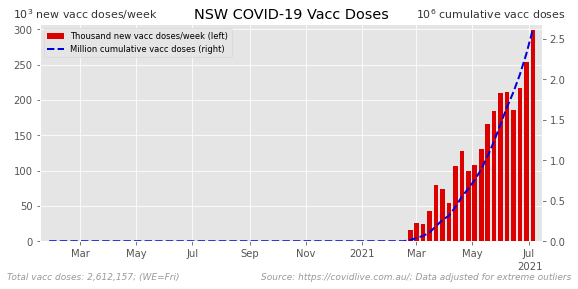

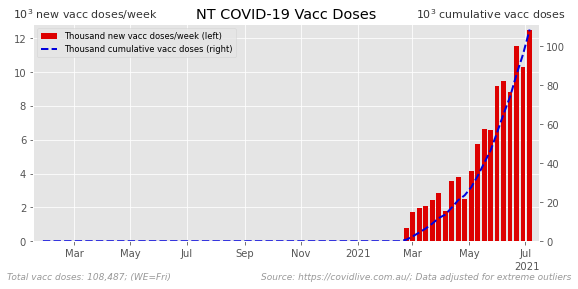

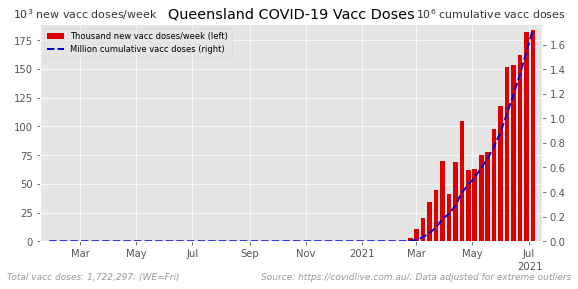

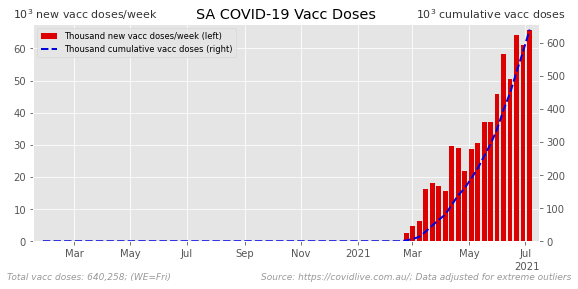

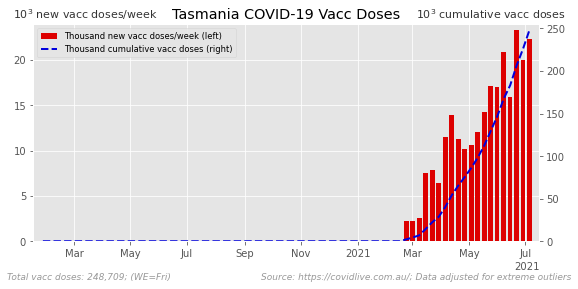

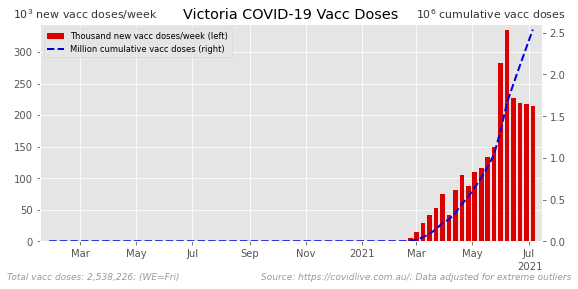

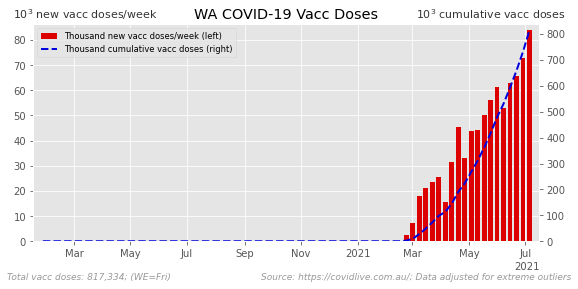

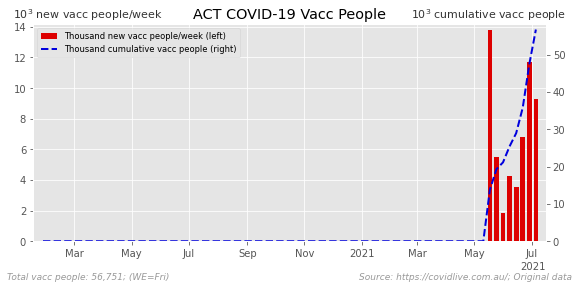

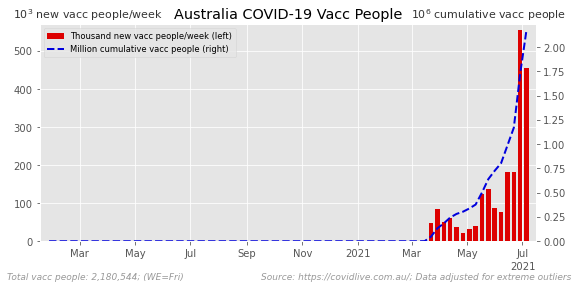

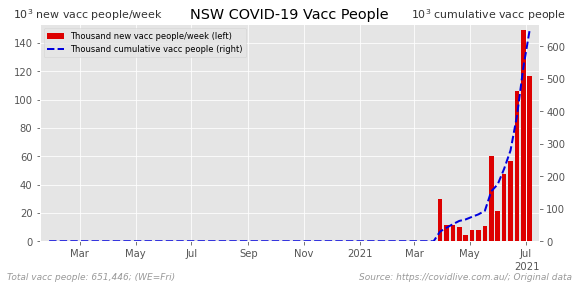

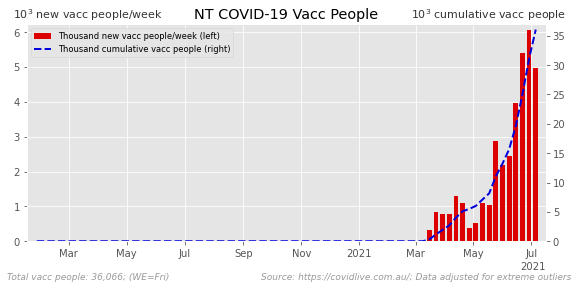

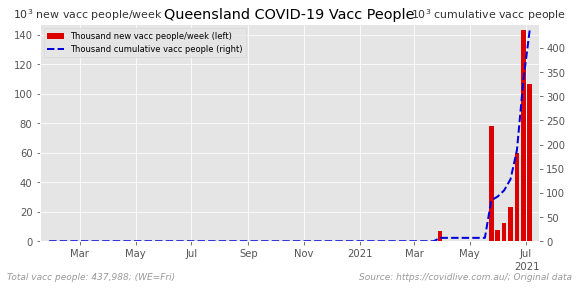

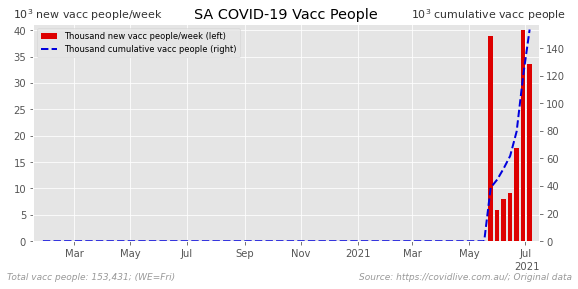

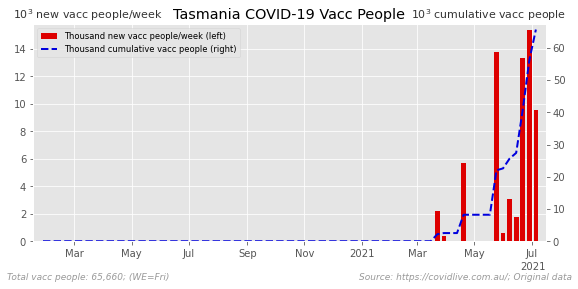

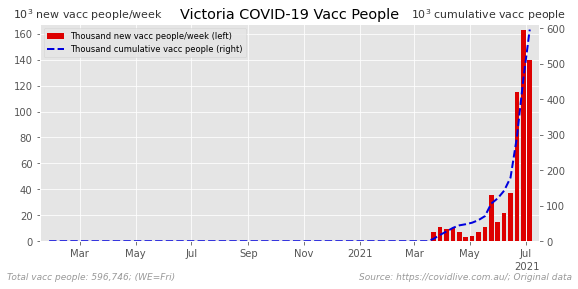

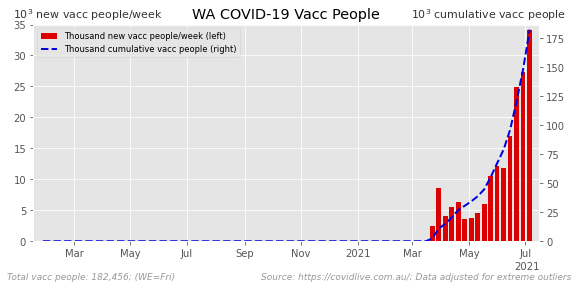

In [12]:
for item, desc in selected_cols.items():
    
    quality = pd.Series(dtype=str)
    for state in daily_u[item].columns:
        if (daily_u[item][state] == daily_c[item][state]).all():
            quality[state] = f'{SOURCE}; Original data'
        else:
            quality[state] = f'{SOURCE}; Data adjusted for extreme outliers'
    
    _ = ps.plot_weekly(
                       daily_c[item], desc, quality, 
                       chart_directory=CHART_DIRECTORY+'-!weekly-',
                       show=True,
                      )

## Bar Charts

In [13]:
def two_bar_plots(data_dict, item, prefix, desc):
    """latest cumulative and cumulative per population charts"""
    
    last_row = data_dict[item].iloc[-1].sort_values()
    #last_row = last_row[last_row > 0]
    if not len(last_row):
        # no data to plot
        return None
    date = data_dict[item].index[-1].ctime()[:10]
    
    for extra in '', f' per {power_text.lower()} population':
        ps.plot_barh(last_row, 
                     title=f'{prefix} COVID19 {desc}{extra}'.strip(),
                     save_as = f'{CHART_DIRECTORY}!bar-chart-{prefix}-{desc}-{extra}.png',
                     rfooter=SOURCE + ' ' + date,
                     show=True,
                    )
        
        # per capita second time round ...
        last_row = (last_row / state_pop).round(1).sort_values()

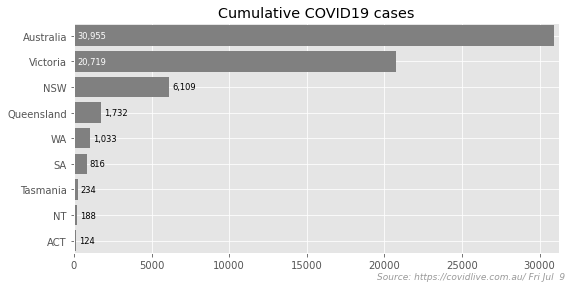

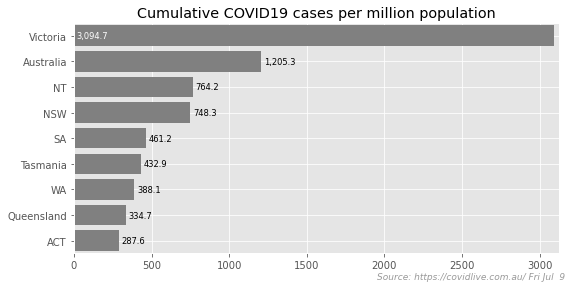

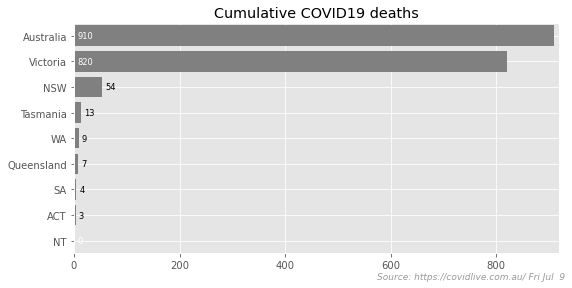

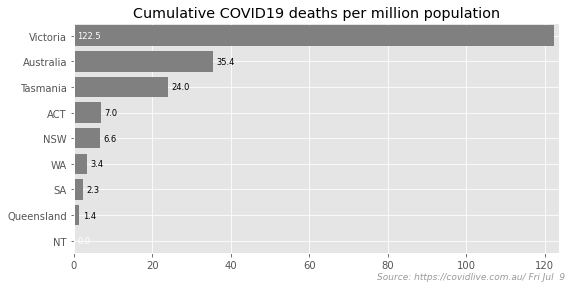

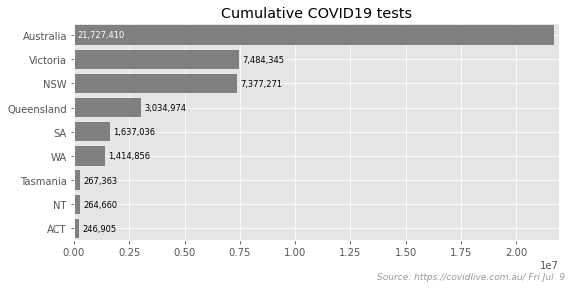

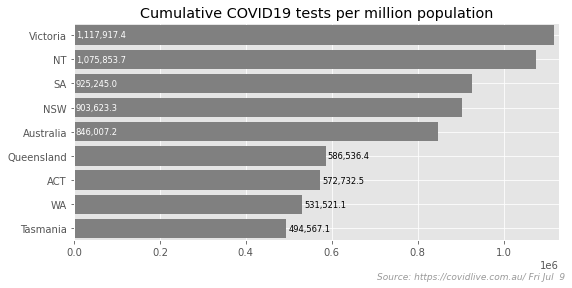

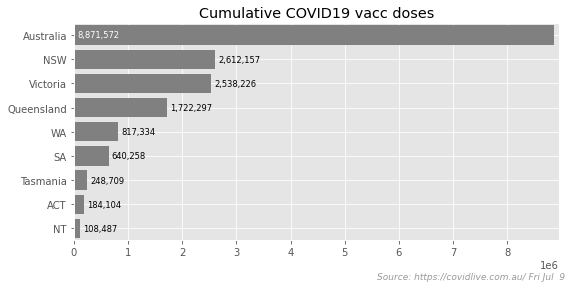

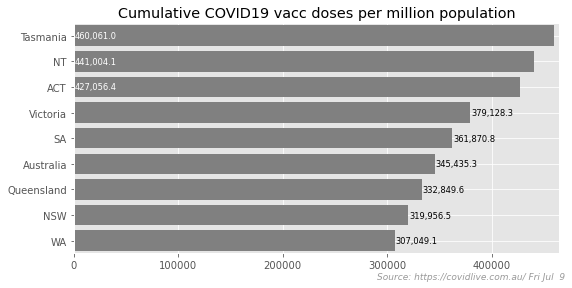

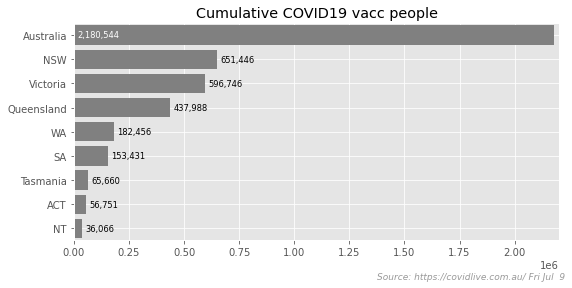

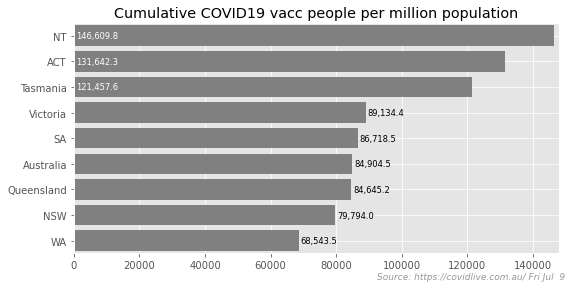

In [14]:
for item, desc in selected_cols.items():
    two_bar_plots(cum_u, item, 'Cumulative', desc)

## Active Cases

In [15]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=AU_COLOURS)

In [16]:
item = 'ACTIVE_CNT'
active_all = (
    get_pivot_table(frame_data, item)
    .dropna(axis=0, how='all')
    .fillna(0)
    .astype(int)
)

Lastest value less than its predecessor in ACTIVE_CNT for Queensland


### Bar chart of active cases

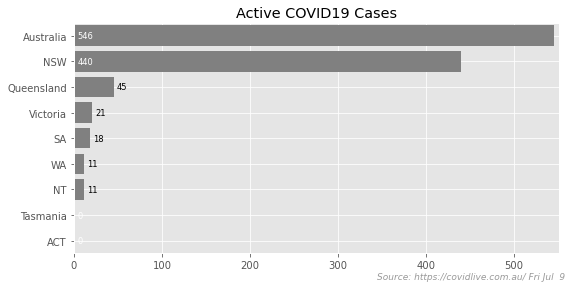

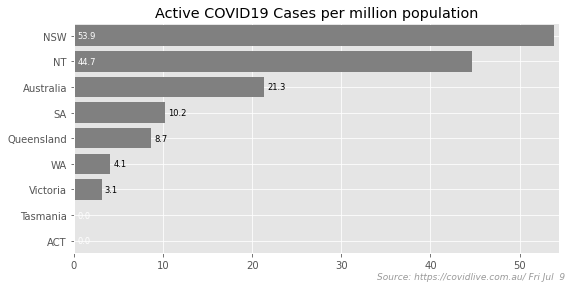

In [17]:
# bar chart of latest active cases
a_dict = {'active': active_all}
two_bar_plots(a_dict, 'active', 'Active', 'Cases')

### Active cases - line plots

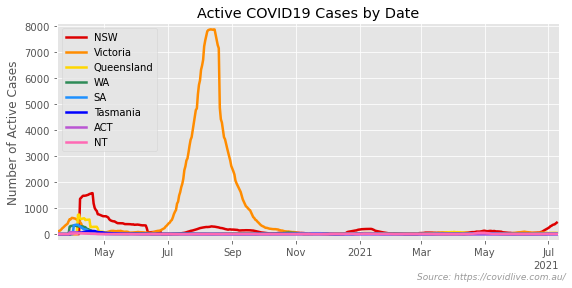

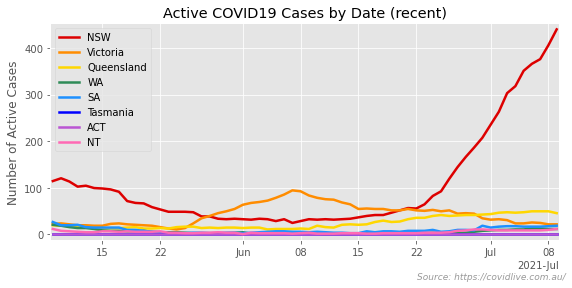

In [18]:
# line plots of trajectories
if 'Australia' in active_all.columns:
    del active_all['Australia']
order = ['NSW', 'Victoria', 'Queensland', 
         'WA', 'SA', 'Tasmania', 'ACT', 'NT']
title = 'Active COVID19 Cases by Date'
MARGINS = (0.005, 0.03)
for recent in [0, RECENT]:
    data = active_all.iloc[-recent:]

    fig, ax = plt.subplots()
    ax.xaxis_date()
    for state in order:
        ax.plot(active_all.index[-recent:].values, 
            active_all[state].iloc[-recent:], 
            label=state, lw=2.5)
    ax.margins(*MARGINS)
    ax.legend(loc='upper left')
    title_extra = ''
    if recent > 0:
        title_extra = ' (recent)'
    
    ps.finalise_plot(ax, title=title+title_extra, 
                     xlabel=None,
                     chart_directory=CHART_DIRECTORY,
                     ylabel='Number of Active Cases',
                     rfooter=SOURCE,
                     show=True,
                    )

## Source of infection

In [19]:
def get_dataset_for_state(raw_data: pd.DataFrame, 
                          columns: List[str], 
                          state: str) -> pd.DataFrame:
    
    # Add in date colums
    sources = columns + ['REPORT_DATE']
    
    # copy rows for relevant state, in respect of the sources columns. 
    df = (
        raw_data[raw_data.NAME == state]
        [sources]
        .copy()
        .set_index('REPORT_DATE')
        .sort_index(ascending=True)
    )

    # check for missing data and warn
    problematic = df.iloc[-1].isna()
    if problematic.any(): # remove last row if partially complete
        warn(f'Missing latest {state} data for '
             f'{", ".join(problematic[problematic].index.to_list())}')
        df.drop(df.tail(1).index, inplace=True)
        
    # check coherence of cumulative data
    summe = df.iloc[-1] < df.iloc[-2]
    if summe.any():
        warn(f'Check {state} where latest less then pred: '
             f'{", ".join(summe[summe].index)}')
        
    df = df.dropna(axis=0, how='all') # remove all empty rows

    return df

In [20]:
# build a dictionary of dataframes for infection source data
names = {
    'SRC_OVERSEAS_CNT':   'Overseas',
    'SRC_INTERSTATE_CNT': 'Interstate',
    'SRC_CONTACT_CNT':    'Known contact',
    'SRC_UNKNOWN_CNT':    'Unknown contact',
    'SRC_INVES_CNT':      'Investigating',
}
# check we have all possible sources ...
assert((frame_data.columns.str[:3] == 'SRC').sum() == len(names))

state_SOI_data = {}
for state in frame_data.NAME.unique():
    state_SOI_data[state]  = (
        get_dataset_for_state(frame_data, list(names.keys()), state)
        .rename(columns=names)
    )

Check Australia where latest less then pred: SRC_INVES_CNT
Check NSW where latest less then pred: SRC_INVES_CNT


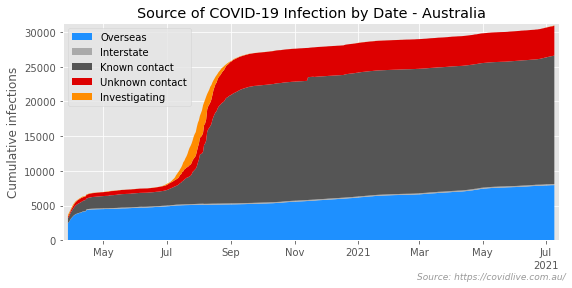

In [21]:
# plot time series of national totals
serious_colours = ['dodgerblue', '#aaaaaa', '#555555', '#dd0000', 'darkorange',]
assert(len(serious_colours) == len(names)) # check we have the right number of colours
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=serious_colours)
national_soi = state_SOI_data['Australia']

labels = list(names.values())
args = [national_soi[name] for name in labels]
fig, ax = plt.subplots()
ax.stackplot(national_soi.index, *args, labels=labels)
ax.legend(loc='upper left')
ax.margins(0.01)

title = 'Source of COVID-19 Infection by Date - Australia'
ps.finalise_plot(ax, title=title, 
                 chart_directory=CHART_DIRECTORY,
                 xlabel=None, ylabel='Cumulative infections',
                 rfooter=SOURCE,
                 show=True,
                )

In [22]:
# extract the latest data, and under investigation
states = list(frame_data.NAME.unique())
states.remove('Australia')
latest = pd.DataFrame()
investigating = pd.DataFrame()
for state in states:
    df = state_SOI_data[state].sort_index()
    df = df.dropna(axis=0, how='all')
    investigating[state] = df['Investigating']
    latest[state] = df.iloc[-1]
    if latest[state].isna().any():
        warn(f'Warning: data not current for {state}')
        print(latest[state][latest[state].isna()])
        latest[state] = df.iloc[-2]
        
latest

,NSW,Victoria,Queensland,WA,SA,Tasmania,ACT,NT
Overseas,3484.0,1198.0,1365.0,919.0,623.0,85.0,95.0,176.0
Interstate,91.0,0.0,25.0,8.0,27.0,3.0,3.0,2.0
Known contact,2045.0,15753.0,293.0,92.0,157.0,141.0,25.0,10.0
Unknown contact,451.0,3768.0,42.0,14.0,9.0,5.0,1.0,0.0
Investigating,38.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0


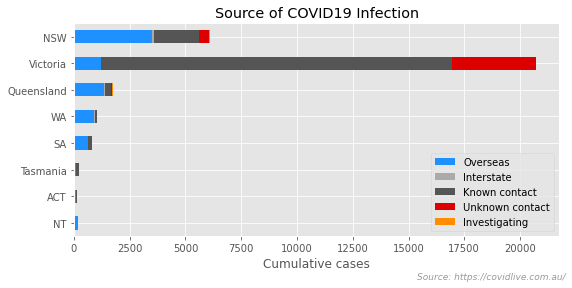

In [23]:
# plot the latest data
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=serious_colours)
ax = latest.T[::-1].plot.barh(stacked=True)
title = 'Source of COVID19 Infection'
ps.finalise_plot(ax, title=title, 
                 chart_directory=CHART_DIRECTORY,
                 xlabel='Cumulative cases', ylabel=None,
                 rfooter=SOURCE,
                 show=True,
                )

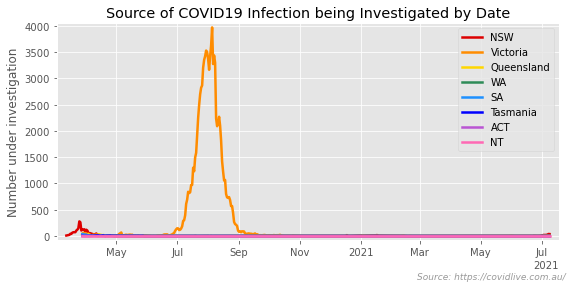

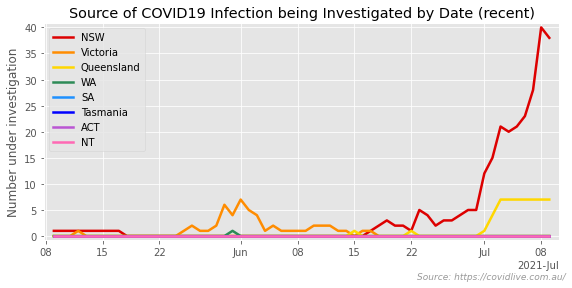

In [24]:
# plot under investigation
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=AU_COLOURS)
for recent in [0, RECENT]:
    fig, ax = plt.subplots()
    ax.margins(0.02)
    for state in investigating.columns:
        ax.plot(investigating.index[-recent:],
                investigating[state].iloc[-recent:],
                lw=2.5, label=state)
    ax.legend(loc='best')
    title = 'Source of COVID19 Infection being Investigated by Date'
    plus = ''
    if recent > 0:
        plus = ' (recent)'

    ps.finalise_plot(ax, 
                     title=title+plus, 
                     chart_directory=CHART_DIRECTORY,
                     xlabel=None, ylabel='Number under investigation',
                     rfooter=SOURCE,
                     show=True,
                    )

## Local cases - speculative 
Note: calculated using the source of infection data

### Create dataframe of local tranmission

In [25]:
# definition of local (Australian) transmission
local_trans = list(names.values())
local_trans.remove('Overseas')
print('Local Transmission:', local_trans)

# calculate from from Sourse of Infection data collected above
local_trans_df = pd.DataFrame()
for state in state_SOI_data:
    local_trans_df[state] = state_SOI_data[state][local_trans].sum(axis=1)

if local_trans_df.iloc[-1].isna().any():
    warn('There are NaNs in the last row of the local transmission data')
    
# Let's look at it ...
local_trans_df.tail()

Local Transmission: ['Interstate', 'Known contact', 'Unknown contact', 'Investigating']


,Australia,NSW,Victoria,Queensland,WA,SA,Tasmania,ACT,NT
REPORT_DATE,,,,,,,,,
2021-07-05,22879.0,2498.0,19521.0,363.0,114.0,193.0,149.0,29.0,12.0
2021-07-06,22898.0,2516.0,19521.0,364.0,114.0,193.0,149.0,29.0,12.0
2021-07-07,22926.0,2543.0,19521.0,365.0,114.0,193.0,149.0,29.0,12.0
2021-07-08,22966.0,2581.0,19521.0,367.0,114.0,193.0,149.0,29.0,12.0
2021-07-09,23010.0,2625.0,19521.0,367.0,114.0,193.0,149.0,29.0,12.0


In [26]:
# make the usual adjustments
LOCAL = 'LOCAL_TRANS'

# the next step assumes the data for today is fully updated.
# but if not, we roll forward yesterday's numbers so that
# the cumulative bar charts (below) are complete.
cum_u[LOCAL] = (
    local_trans_df
    .sort_index(ascending=True)
    .replace({0: np.nan})
    .ffill()
    .fillna(0)
    .astype(int)
)

daily_u[LOCAL], daily_c[LOCAL], cum_c[LOCAL] = (
    ps.dataframe_correction(cum_u[LOCAL], verbose=False)
)

### Bar charts cumulative local transmission

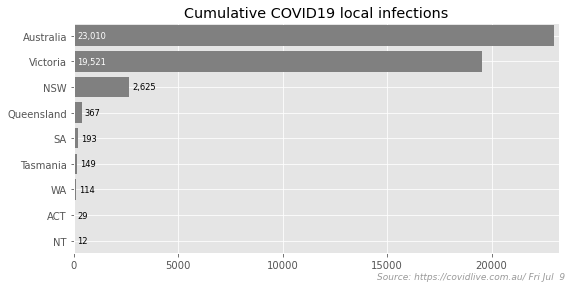

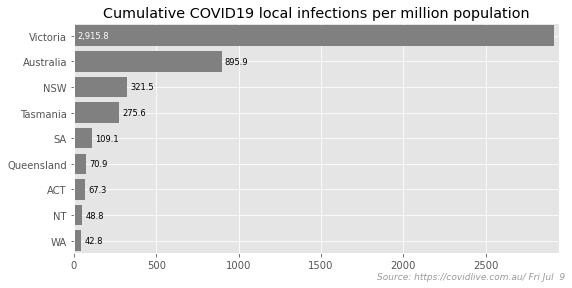

In [27]:
two_bar_plots(cum_u, LOCAL, 'Cumulative', 'local infections')

### Weekly charts for local transmission

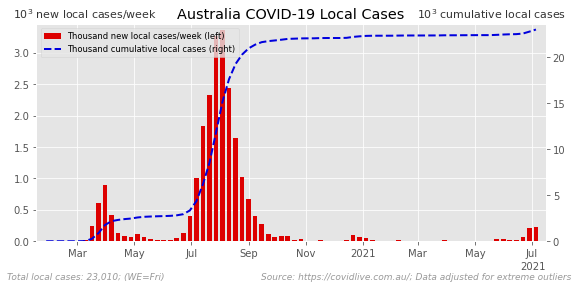

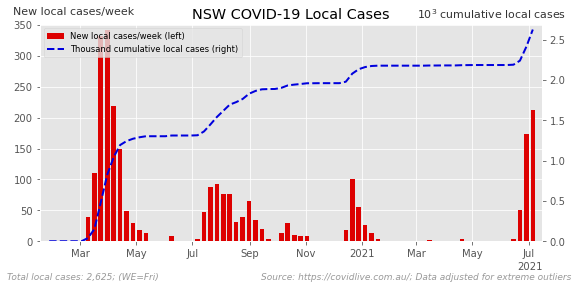

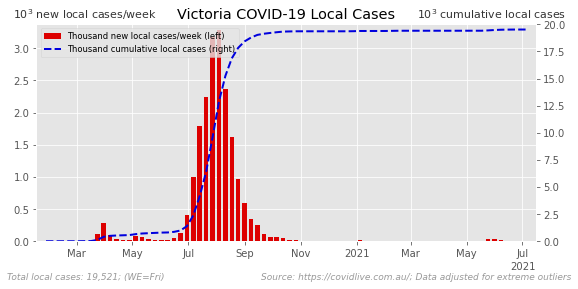

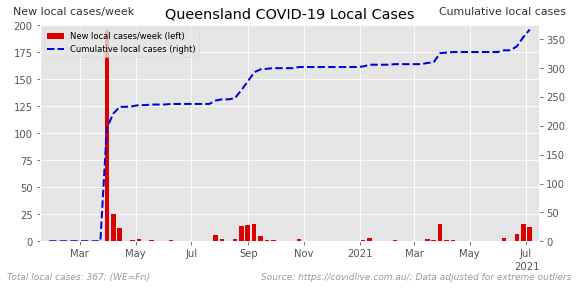

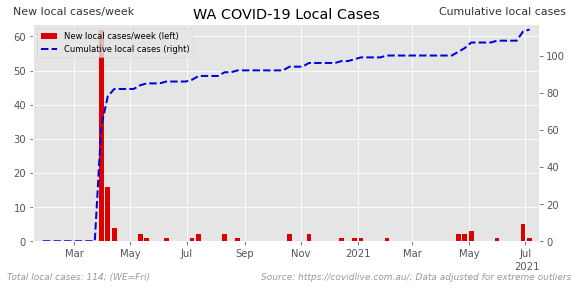

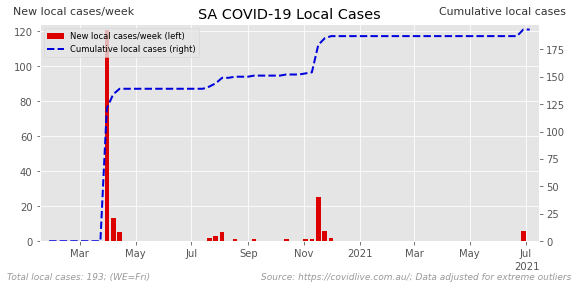

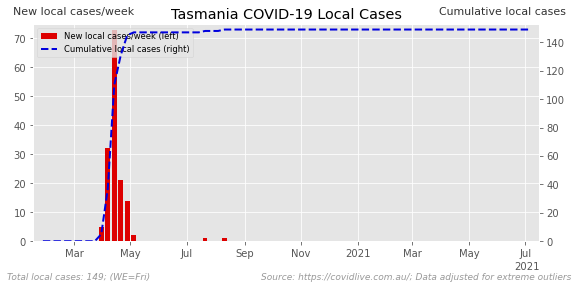

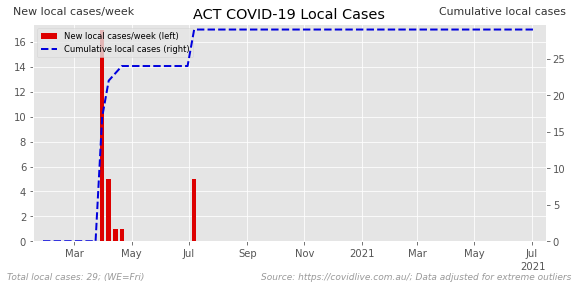

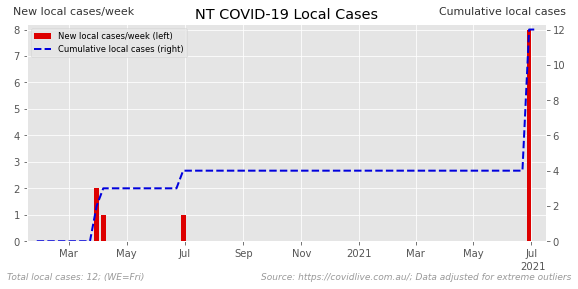

In [28]:
quality = pd.Series(dtype=str)
for state in daily_u[LOCAL].columns:
    if (daily_u[LOCAL][state] == daily_c[LOCAL][state]).all():
        quality[state] = f'{SOURCE}; Original data'
    else:
        quality[state] = f'{SOURCE}; Data adjusted for extreme outliers'

desc = 'local cases'
_ = ps.plot_weekly(
    daily_c[LOCAL], desc, quality, 
    chart_directory=f'{CHART_DIRECTORY}-!{desc}-',
    show=True,
)

### Recent local transmission daily charts

In [29]:
local_lfooter = f'Local = {" + ".join(local_trans)}'

def recent_bar_with_ma_plot(df, mode):
    """plotting function - bar charts for daily local transmission,
       with 7 and 14 day moving averages."""
    
    # establish moving average periods
    MA1 = 7 # days
    MA2 = 14 # dats
    
    for col in df.columns:
        series = df[col]
        
        # bail if nothing to plot
        if series[-RECENT:].sum() <= 0: 
            continue
            
        # get plotables for recent period
        ma1 = series.rolling(MA1).mean()[-RECENT:]
        ma2 = series.rolling(MA2).mean()[-RECENT:]
        series = series[-RECENT:]
        
        # plot
        MARGINS = 0.015
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(MARGINS) # seems to work here
        ax.bar(series.index, series, label=mode, 
               color='#dd0000')
        ax.plot(ma1.index, ma1, label=f'{MA1} day ave.', 
                color='darkorange')
        ax.plot(ma2.index, ma2, label=f'{MA2} day ave.', 
                color='cornflowerblue')
        
        # annotate / finalise plot
        ax.legend(loc='best')
        title = (f'New Locally Acquired COVID19 {mode.title()} '
                 f'in {col} - Recent')
        ps.finalise_plot(ax, 
                         title=title, 
                         chart_directory=f"{CHART_DIRECTORY}-recent-local-",
                         xlabel=None,
                         ylabel=f'Daily New {mode.title()}',
                         lfooter=local_lfooter,
                         rfooter=SOURCE,
                         show=True,
                        )

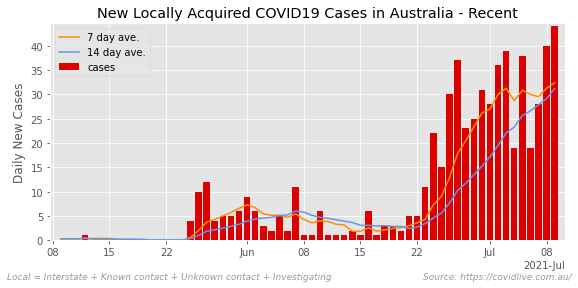

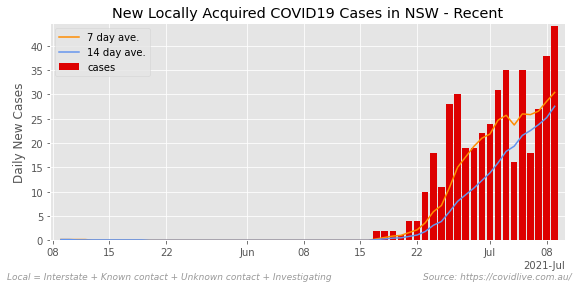

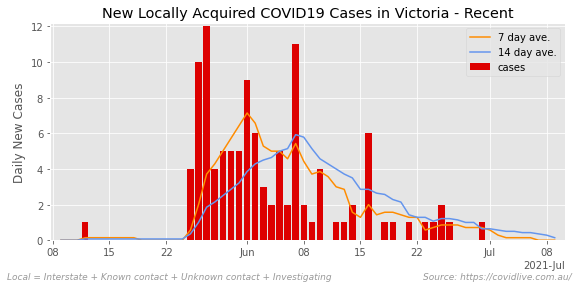

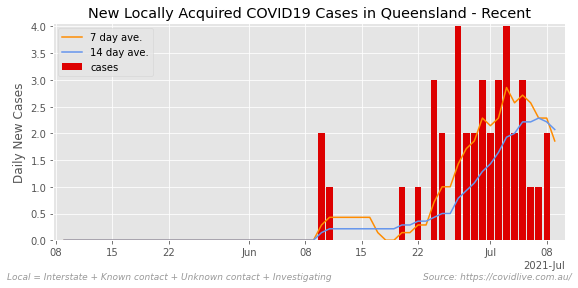

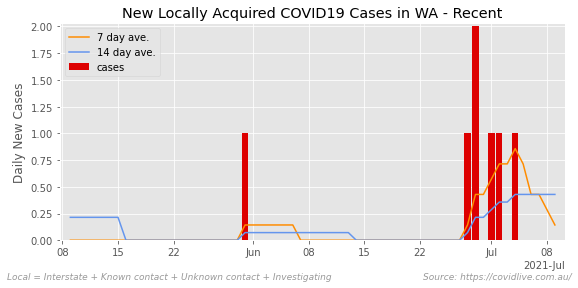

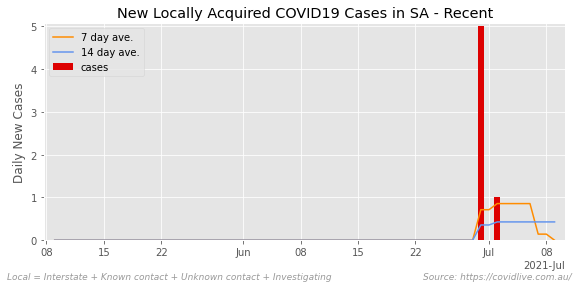

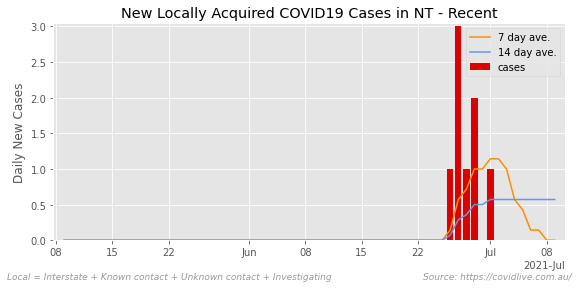

In [30]:
# and plot it
recent_bar_with_ma_plot(daily_c[LOCAL], "cases")

### Compare Sydney and Melbourne outbreaks

Note: requires the data for today to be updated.

In [31]:
def select(state, start_date, span_days=41):
    series = daily_c[LOCAL][state]
    return (
        series[series.index >= pd.Timestamp(start_date)]
        .iloc[:span_days]
        .reset_index(drop=True)
    )


def get_outbreaks():
    outbreaks = {
        # Label       #[state, last zero-day before outbreak]
        #'Tas Apr-20':  ['Tasmania', '2020-04-02'],
        #'SA Nov-20':   ['SA',       '2020-11-14',],
        'NSW Dec-20':  ['NSW',        '2020-12-16',],
        'Vic May-21':  ['Victoria',   '2021-05-24'],
        'Qld Jun-21':  ['Queensland', '2021-06-19'],
        'NSW Jun-21':  ['NSW',        '2021-06-16'],
        
    }

    outbreak_df = pd.DataFrame()
    for label, (state, start_date) in outbreaks.items():
        print(state, start_date)
        outbreak_df[label] = select(state, start_date)
        
    title = f'Outbreaks compared: {", ".join(outbreaks.keys())}'
    
    print(outbreak_df.iloc[0])
    print(outbreak_df.iloc[1])

    return outbreak_df, title

NSW 2020-12-16
Victoria 2021-05-24
Queensland 2021-06-19
NSW 2021-06-16
NSW Dec-20    0.0
Vic May-21    0.0
Qld Jun-21    0.0
NSW Jun-21    0.0
Name: 0, dtype: float64
NSW Dec-20    3.0
Vic May-21    4.0
Qld Jun-21    1.0
NSW Jun-21    2.0
Name: 1, dtype: float64


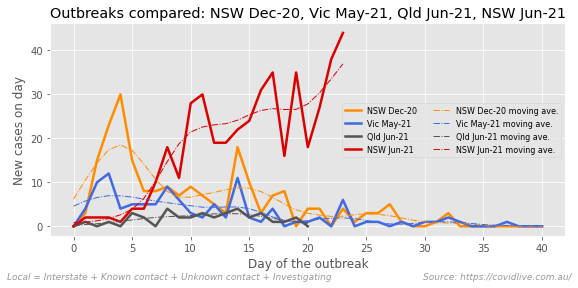

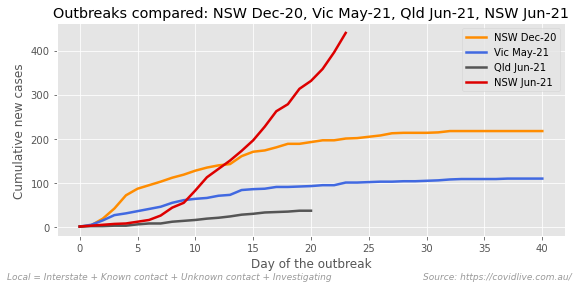

In [32]:
comparable, title = get_outbreaks()
colors = ['darkorange', 'royalblue', '#555555', '#dd0000', ]
ylabels =  ['New cases on day', 'Cumulative new cases']
datasets = [comparable, comparable.cumsum()]

for ylabel, data in zip(ylabels, datasets):
    
    # plot primary data
    ax = data.plot(color=colors, lw=2.5)
    
    # add Henderson moving averages if we have enough data
    MA_TERM = 13 # must be odd
    if ylabel == ylabels[0] and len(data) >= MA_TERM:
        hma = pd.DataFrame()
        for col in data.columns:
            input_ = data[col].dropna()
            if len(input_) >= MA_TERM:
                hma[col] = Henderson.Henderson(input_, MA_TERM)
        if not hma.empty:
            hma.columns = hma.columns + ' moving ave.'
            hma.plot(color=colors, lw=1, ls='-.', ax=ax)
            ax.legend(ncol=2, prop={'size': 8})
    
    # and finalise the plot
    ps.finalise_plot(ax,
                 title=title, 
                 chart_directory=f"{CHART_DIRECTORY}",
                 ylabel=ylabel,
                 xlabel=f'Day of the outbreak',
                 save_tag=ylabel.split()[0],
                 lfooter=local_lfooter,
                 rfooter=SOURCE,
                 show=True,
    )

### The bigger cumulative comparison
*  After the first wave in March/April 2020
*  Wave larger than 100 cases in total

,NSW 08-Jul-20 (Crossroads),NSW 16-Dec-20 (Avalon),NSW 16-Jun-21 (Bondi),Vic 09-Jun-20 (2nd Wave),Vic 24-May-21 (Wollert)
0,0.0,0.0,0.0,0.0,0.0
1,2.0,3.0,2.0,4.0,4.0
2,3.0,18.0,4.0,12.0,14.0
3,5.0,41.0,6.0,13.0,26.0
4,8.0,71.0,7.0,19.0,30.0


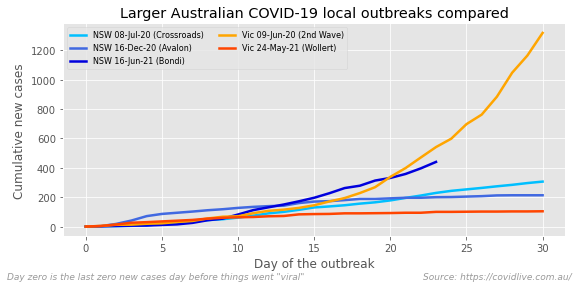

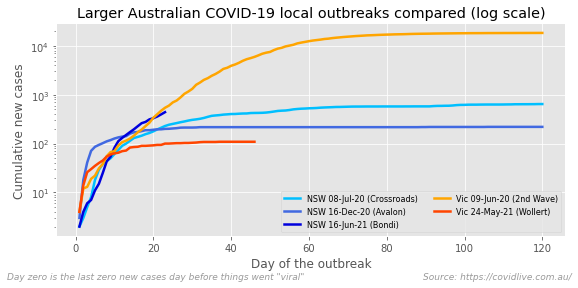

In [33]:
outbreaks = {
    'NSW 08-Jul-20 (Crossroads)':    ['NSW',      '2020-07-08'],
    'NSW 16-Dec-20 (Avalon)':        ['NSW',      '2020-12-16'],
    'NSW 16-Jun-21 (Bondi)':         ['NSW',      '2021-06-16'],
    'Vic 09-Jun-20 (2nd Wave)':      ['Victoria', '2020-06-09'],
    'Vic 24-May-21 (Wollert)':       ['Victoria', '2021-05-24'],
}
colors = ['deepskyblue', 'royalblue', '#0000dd', 'orange', 'orangered', ]
MAXIMUM = 121

outbreak_df = pd.DataFrame()
for label, (state, start_date) in outbreaks.items():
    outbreak_df[label] = select(state, start_date, span_days=MAXIMUM).cumsum()

display(outbreak_df.head())  

for log in [0, 1]:
    maximum = 31 if not log else MAXIMUM
    minimum = 0  if not log else 1
    ax = outbreak_df[minimum:maximum].plot(color=colors[:len(outbreak_df.columns)], lw=2.5)
    title = 'Larger Australian COVID-19 local outbreaks compared'
    if log: 
        ax.set_yscale('log')
        title += ' (log scale)'
    ax.legend(ncol=2, prop={'size': 8})
    ps.finalise_plot(ax,
                 title=title, 
                 chart_directory=f"{CHART_DIRECTORY}",
                 ylabel='Cumulative new cases',
                 xlabel=f'Day of the outbreak',
                 #save_tag=ylabel.split()[0],
                 lfooter='Day zero is the last zero new cases day before things went "viral"',
                 rfooter=SOURCE,
                 show=True,
)

### Bond/Sydney Local Cases Growth Factor

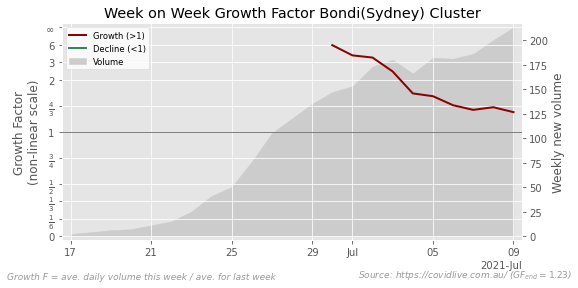

In [34]:
nsw = daily_c[LOCAL]['NSW']
nsw = nsw[nsw.index > pd.Timestamp('2021-06-16')]

ps.plot_growth_factor(
    nsw,
    title='Week on Week Growth Factor Bondi(Sydney) Cluster', 
    chart_directory=f"{CHART_DIRECTORY}",
    ylabel='Growth Factor',
    xlabel=None,
    rfooter=SOURCE,
    show=True,
)

## Hospitalised

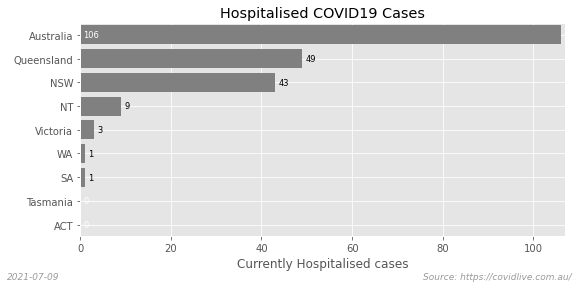

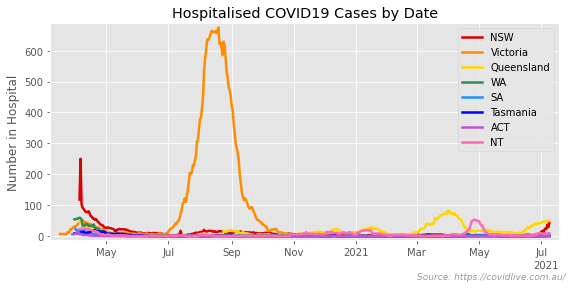

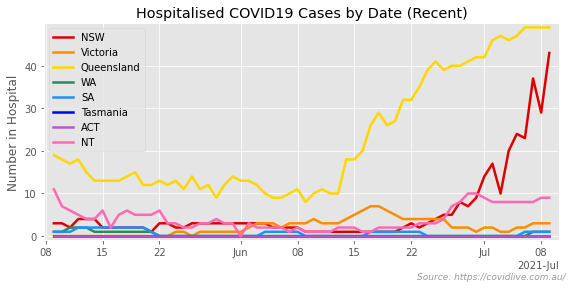

Lastest value less than its predecessor in MED_ICU_CNT for Australia, NSW


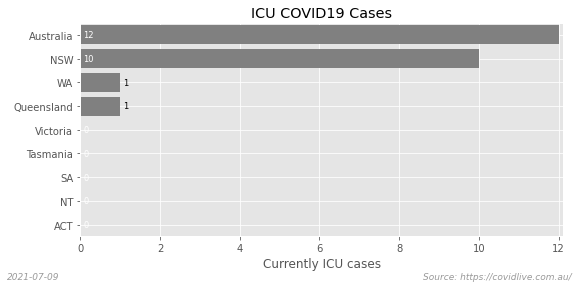

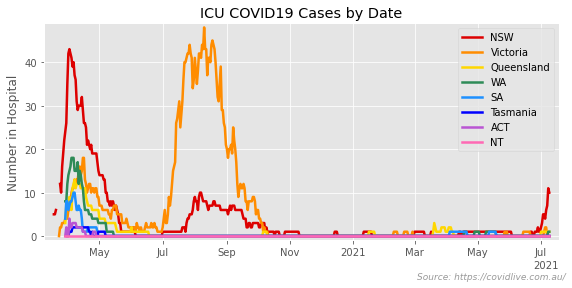

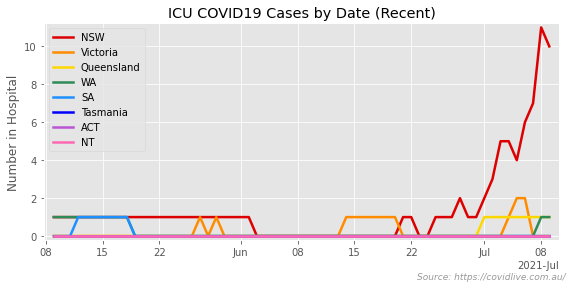

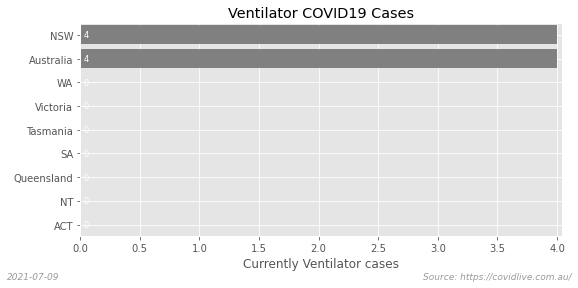

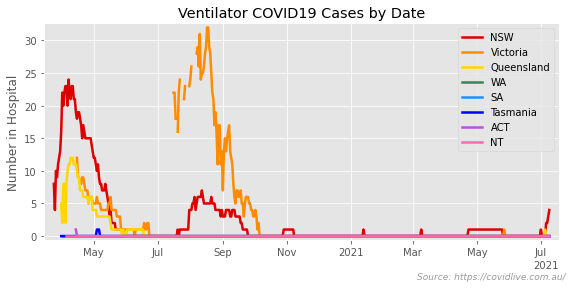

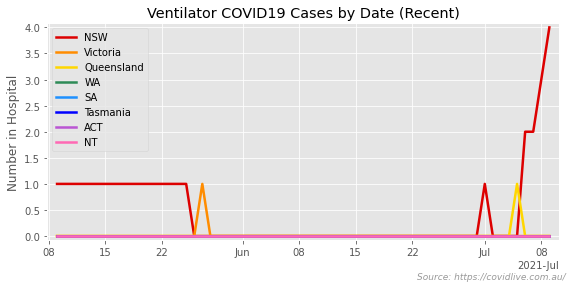

In [35]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=AU_COLOURS)
idents = ['MED_HOSP_CNT', 'MED_ICU_CNT', 'MED_VENT_CNT']
descs = ['Hospitalised', 'ICU', 'Ventilator']

for ident, desc in zip(idents, descs):

    hospital = get_pivot_table(frame_data, ident)
    hospital.index = pd.DatetimeIndex(hospital.index)
    hospital = hospital.dropna(axis=0, how='all')

    # bar chart of latest data
    latest = hospital.copy()
    if latest.iloc[-1].isna().any():
        latest.drop(latest.index[-1], inplace=True)
    row = latest.iloc[-1].astype(int)
    if row.sum() > 0:
        lfooter = str(row.name.date())
        title = f'{desc} COVID19 Cases'
        ps.plot_barh(row.sort_values(ascending=True), 
                     title=title,
                     xlabel=f'Currently {desc} cases',
                     save_as = f'{CHART_DIRECTORY}{title}.png',
                     rfooter=SOURCE,
                     lfooter=lfooter,
                     show=True,
                    )
    
    # plot hospitalised as a line chart
    for start in [0, -RECENT]:
        dataset = hospital.iloc[start:]
        if dataset.sum().sum() == 0:
            continue
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(0.02)
        for state in order:
            ax.plot(dataset.index, 
                    dataset[state], 
                    label=state, lw=2.5)
        ax.legend(loc='best')

        title = f'{desc} COVID19 Cases by Date'
        if start == -RECENT:
            title += ' (Recent)'
        ps.finalise_plot(ax, 
                         title=title, 
                         chart_directory=CHART_DIRECTORY,
                         xlabel=None,
                         ylabel='Number in Hospital',
                         rfooter=SOURCE,
                         show=True,
                        )

## The End

In [36]:
print_warnings()
print('Finished')

NOTE: 4 warnings
Lastest value less than its predecessor in ACTIVE_CNT for Queensland
Check Australia where latest less then pred: SRC_INVES_CNT
Check NSW where latest less then pred: SRC_INVES_CNT
Lastest value less than its predecessor in MED_ICU_CNT for Australia, NSW
Finished
